In [1]:
from IPython.display import display, Math, Latex,HTML
%matplotlib inline
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from glob import glob


# Propagation Network

In [2]:
statusLabel = ['Born in Canada', 'Immigrants, landed 5 or less years earlier',
               'Immigrants, landed more than 10 years earlier',
               'Immigrants, landed more than 5 to 10 years earlier']

educationLabel = ['0 to 8  years', 'Some high school',
       'High school graduate', 'Some postsecondary',
       'Postsecondary certificate or diploma', 'University degree']

df = pd.read_csv("demographics.csv")
df2 = df.groupby("Country of origin").sum()
df2 = df2.sort_values(by=["Total"],ascending=False)[:11]
df2 = df2.sort_values(by = [ "Country of origin", "Year"])
countryLabel = list(df2.index)

for index in range(len(countryLabel)):
    if countryLabel[index] == "Unknown ":
        del countryLabel[index]
        break

ageLabel = ["0 - 4",
            "5 - 11",
            "12 - 17",
            "18 - 59",
            "60",
            "other"]

ageLabel_ER = ['15 to 24 years',
               '25 to 54 years',
               '55 to 64 years',
               '65 years and over']

sexLabel = ["Female", "Male"]

initYear = 2015
yearLabel = [str(i+initYear) for i in range(8)]

provinceLabel = ["Newfoundland and Labrador",
                "Prince Edward Island",
                "Nova Scotia",
                "New Brunswick",
                "Quebec",
                "Ontario",
                "Manitoba",
                "Saskatchewan",
                "Alberta",
                "British Columbia",
                "Yukon",
                "Northwest Territories",
                "Nunavut"]

provinceLabel = provinceLabel[:-3]



In [3]:
model = []
model.append(gum.BayesNet())
model[0].add(gum.LabelizedVariable('Year','Year',yearLabel))
model[0].add(gum.LabelizedVariable('Province','Province',provinceLabel))
model[0].add(gum.NumericalDiscreteVariable("Economic","Economic",range(0,150)))
model[0].add(gum.NumericalDiscreteVariable("Sponsor","Sponsor",range(0,70)))
model[0].add(gum.NumericalDiscreteVariable("Refugee","Refugee",range(0,50)))

model[0].addArc('Year','Sponsor')
model[0].addArc('Year','Refugee')
model[0].addArc('Year','Economic')
model[0].addArc('Year','Province')

model[0].addArc('Province','Sponsor')
model[0].addArc('Province','Refugee')
model[0].addArc('Province','Economic')

model.append(gum.BayesNet())
model[1].add(gum.LabelizedVariable('Year','Year',yearLabel))
model[1].add(gum.LabelizedVariable('Origin','Origin',countryLabel))
model[1].add(gum.LabelizedVariable('Age','Age',ageLabel))
model[1].add(gum.LabelizedVariable('Sex','Sex',sexLabel))

model[1].addArc('Year','Origin')
model[1].addArc('Origin','Age')
model[1].addArc('Origin','Sex')

model.append(gum.BayesNet())
model[2].add(gum.LabelizedVariable('Year','Year',yearLabel))
model[2].add(gum.LabelizedVariable('Province','Province',provinceLabel))
model[2].add(gum.LabelizedVariable('Status','Status',statusLabel)) 
model[2].add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

model[2].addArc('Year','Employment Rate')
model[2].addArc('Province','Employment Rate')
model[2].addArc('Status','Employment Rate')

model.append(gum.BayesNet())
model[3].add(gum.LabelizedVariable('Year','Year',yearLabel))
model[3].add(gum.LabelizedVariable('Province','Province',provinceLabel))
model[3].add(gum.LabelizedVariable('Age','Age',ageLabel_ER))
model[3].add(gum.LabelizedVariable('Sex','Sex',sexLabel))
model[3].add(gum.LabelizedVariable('Education','Education',educationLabel)) 
model[3].add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

model[3].addArc('Year','Employment Rate')
model[3].addArc('Province','Employment Rate') 
model[3].addArc('Age','Employment Rate')
model[3].addArc('Sex','Employment Rate')
model[3].addArc('Education','Employment Rate')

# model.append(gum.BayesNet())
# model[4].add(gum.NumericalDiscreteVariable('ER_Status','ER_Status',range(0,101))) 
# model[4].add(gum.NumericalDiscreteVariable('ER_Education','ER_Education',range(0,101))) 
# model[4].add(gum.NumericalDiscreteVariable('Employment Rate','Employment Rate',range(0,101))) 

# model[4].addArc('ER_Education','Employment Rate')
# model[4].addArc('ER_Status','Employment Rate')

gnb.sideBySide(*[gnb.getBN(model[i]) for i in range(len(model))])


G <!-- Sex --> Sex Sex <!-- Year --> Year Year <!-- Origin --> Origin Origin <!-- Year->Origin --> Year->Origin <!-- Origin->Sex --> Origin->Sex <!-- Age --> Age Age <!-- Origin->Age --> Origin->Age,G <!-- Year --> Year Year <!-- Employment Rate --> Employment Rate Employment Rate <!-- Year->Employment Rate --> Year->Employment Rate <!-- Status --> Status Status <!-- Status->Employment Rate --> Status->Employment Rate <!-- Province --> Province Province <!-- Province->Employment Rate --> Province->Employment Rate


# RSE Network

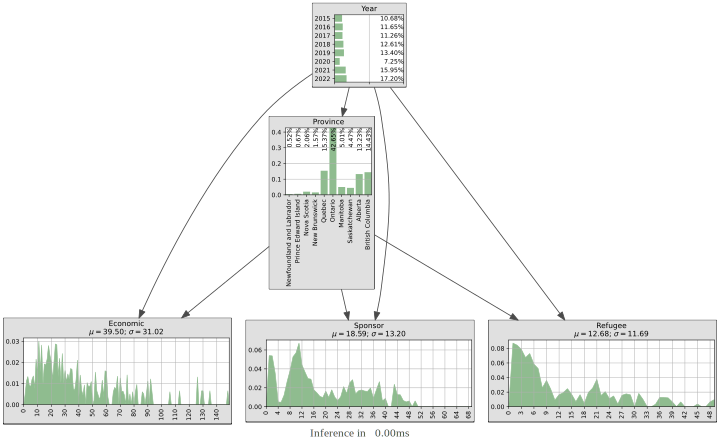

In [4]:
df = {}
pr = {p:{y:0 for y in provinceLabel} for p in yearLabel}

for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    df[p] = data.iloc[:,1:]
    
    for year in yearLabel:
        year_diff = int(year)-initYear
        pr[year][p] = np.sum(df[p].Total[year_diff*12: (year_diff+1) * 12])

year_data = []
for y in yearLabel:
    model[0].cpt("Province")[{"Year":y}]= pr[y]
    year_data.append(sum(pr[y].values()))
model[0].cpt("Year")[:] =year_data 



rangeNode = {"Economic": 150,
             "Sponsor": 70,
             "Refugee": 50,
            }

coeff = {"Economic": 100,
         "Sponsor": 100,
         "Refugee": 100,
        }

pr = {p:{y:{d:0 for d in rangeNode.keys()} for y in yearLabel} for p in provinceLabel}

maxRange = 500
bins={n:[i for i in range(maxRange)] for n in rangeNode.keys()}
for n in rangeNode.keys():
    bins[n] = bins[n][:rangeNode[n]]
    
    for i in range(len(bins[n])):
        bins[n][i] = coeff[n]*bins[n][i]
      
    bins[n].insert(0,0)
    bins[n][-1] = 1000000
    
for index, p in enumerate(provinceLabel):
    path = r".\data_csv\\" + p + ".csv"
    data = pd.read_csv(path)
    province_df = data.iloc[:,1:]
    
    for yIndex, y in enumerate(yearLabel):
        yearly_province_df = province_df.iloc[yIndex*12:(yIndex+1)*12]
        
        for d in rangeNode.keys():
            arr = np.array(yearly_province_df[d])

            hist = np.histogram(arr, bins[d])[0]
            pr[p][y][d]=  hist/sum(hist)
        
for index, p in enumerate(provinceLabel):
    for yIndex, y in enumerate(yearLabel):
        dictionary={"Province":p,"Year":y}
        model[0].cpt("Economic")[dictionary] = pr[p][y]["Economic"]
        model[0].cpt("Sponsor")[dictionary] = pr[p][y]["Sponsor"]
        model[0].cpt("Refugee")[dictionary] = pr[p][y]["Refugee"]   
        
model[0].cpt("Year").normalizeAsCPT()
model[0].cpt("Province").normalizeAsCPT()
model[0].cpt("Refugee").normalizeAsCPT()
model[0].cpt("Sponsor").normalizeAsCPT()
model[0].cpt("Economic").normalizeAsCPT()

gnb.showInference(model[0], evs={},size="10")

# Country of Origin Network

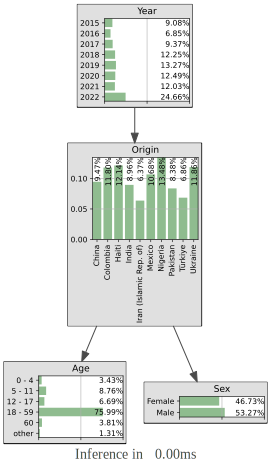

In [5]:
df = pd.read_csv("demographics.csv")
df = df[df["Country of origin"].isin(countryLabel)]
df_CoO = df.groupby(["Year"]).sum()

model[1].cpt("Year")[:] = [value for value in df_CoO.loc[:,"Total"]]

df_CoO = df.groupby(["Year","Country of origin"]).sum()

for year in yearLabel:
    year_dictionary = {"Year":year}
    origin_data = []
    for country in countryLabel:
        temp = df_CoO.loc[int(year)].loc[country].Total
                    
        origin_data.append(temp)

    model[1].cpt("Origin")[year_dictionary] = origin_data

    
df_CoO = df.groupby("Country of origin").sum()
female = np.array(df_CoO.iloc[:]["Female total"])
male = np.array(df_CoO.iloc[:]["Male total"])

model[1].cpt("Sex")[:] = np.swapaxes(np.vstack((female,male)),0,1)

for cLabel in countryLabel:
    temp_df = df_CoO.loc[cLabel]
    age_data = []
    for aLabel in ageLabel:
        value = 0
        for gLabel in sexLabel:
            value += temp_df.iloc[:][gLabel+" " +aLabel]
        age_data.append(value)
        
    model[1].cpt("Age")[{"Origin":cLabel}] = age_data
    
model[1].cpt("Year").normalizeAsCPT()
model[1].cpt("Origin").normalizeAsCPT()
model[1].cpt("Age").normalizeAsCPT()
model[1].cpt("Sex").normalizeAsCPT()

gnb.showInference(model[1], evs={},size="10")    

# Immigrant Status Network

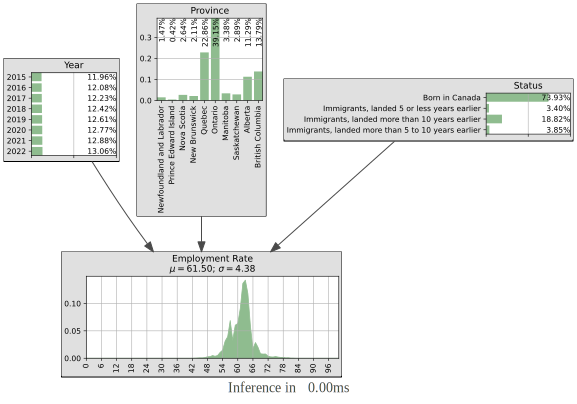

In [6]:
population_df = pd.read_csv("population_immigration.csv")
er_df = pd.read_csv("employment_immigration.csv")

population_df = population_df.loc[:, ["REF_DATE","GEO","Immigrant status","VALUE"]]
population_df.columns = ["Date", "Province", "Status","Population"]

er_df = er_df.loc[:, ["VALUE"]]
er_df.columns = ["Employment Rate"]

pop_er_df = population_df.join(er_df)

temp = pop_er_df
temp = temp.loc[:,"Population"] * temp.loc[:,"Employment Rate"]/100

pop_er_df = pop_er_df.join(pd.DataFrame(temp, columns=["Population ER"]))

avg_df = pop_er_df[pop_er_df["Province"]=="Canada"]
model[2].cpt("Status")[:] = [avg_df.groupby("Status").mean().Population[i] for i in range(len(statusLabel))]

avg_df =  pop_er_df[pop_er_df["Status"]=="Total population"].groupby("Province").mean()
for province in provinceLabel:
    dictionary = {"Province":province}
    model[2].cpt("Province")[dictionary] = avg_df.loc[province, "Population"]

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Status"]=="Total population")]

year_data = []
for y in yearLabel:
    index = int(y) - initYear
    year_data.append(np.mean(avg_df.iloc[index*12: (index+1)*12].Population))
    
model[2].cpt("Year")[:] = year_data

avg_df=  pop_er_df.groupby(["Province","Status","Date"]).mean()
for province in provinceLabel:
    for status in statusLabel:
        yearly_province_df = avg_df.loc[province].loc[status]
        
        for index, year in enumerate(yearLabel):
            dictionary = {"Year":year, "Province":province, "Status":status}

            arr = np.array(yearly_province_df.iloc[index*12:(index+1)*12,1])
            arr = arr[~np.isnan(arr)]
            hist = np.histogram(arr, 101, (0,100))[0]
            data =  hist/sum(hist)

            model[2].cpt("Employment Rate")[dictionary] = data


model[2].cpt("Year").normalizeAsCPT()
model[2].cpt("Province")
model[2].cpt("Status")
model[2].cpt("Employment Rate")
        
gnb.showInference(model[2], evs={},size="10")       
       

# Education Network

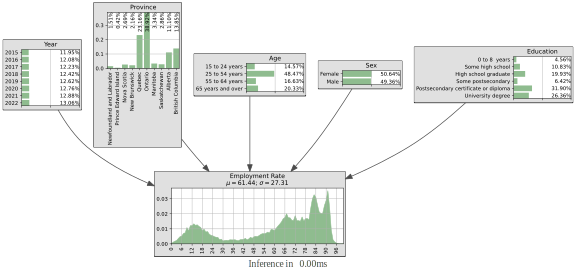

In [7]:
pop_er_df = pd.read_csv("employment_education_complete.csv")
pop_er_df = pop_er_df.loc[:, ["REF_DATE","GEO","Sex", "Age group", "UOM", "Educational attainment","VALUE"]]
pop_er_df.columns = ["Date", "Province", "Sex", "Age", "UOM", "Education","Population"]

a = pop_er_df[pop_er_df["UOM"]=="Persons"]
b = pop_er_df[pop_er_df["UOM"]=="Percentage"].loc[:,["Population"]]
b.columns = ["Employment Rate"]

a.reset_index(inplace=True)
del a["index"]
b.reset_index(inplace=True)
del b["index"]
pop_er_df = a.join(b)
del pop_er_df["UOM"]

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Education"]=="Total, all education levels")]
avg_df = avg_df.groupby(["Sex","Age"]).mean()
avg_df = avg_df.groupby("Age").sum()
model[3].cpt("Age")[:] = [avg_df.loc[age][0] for age in ageLabel_ER] 
               
avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Age"]=="15 years and over") & (pop_er_df["Education"]=="Total, all education levels")]
avg_df = avg_df.groupby(["Sex"]).mean()
model[3].cpt("Sex")[:] = [avg_df.loc["Females"][0], avg_df.loc["Males"][0]]

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Education"]=="Total, all education levels")]
avg_df = avg_df.groupby(["Date","Sex"]).mean()
avg_df = avg_df.groupby("Date").sum()

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada")
                   & (pop_er_df["Education"]=="Total, all education levels")
                   & (pop_er_df["Age"]=="15 years and over")]
avg_df = avg_df.groupby(["Date"]).sum()

year_data = []
for y in yearLabel:
    index = int(y) - initYear
    year_data.append(np.mean(avg_df.iloc[index*12: (index+1)*12].Population))
    
model[3].cpt("Year")[:] = year_data

avg_df = pop_er_df[(pop_er_df["Province"]=="Canada") & (pop_er_df["Age"]=="15 years and over")]
avg_df = avg_df.groupby(["Education","Sex"]).mean()
avg_df = avg_df.groupby("Education").sum()
model[3].cpt("Education")[:] = [avg_df.loc[education][0] for education in educationLabel] 

avg_df = pop_er_df.groupby(["Education","Sex","Province"]).mean()
avg_df = avg_df.groupby(["Education","Province"]).sum()
avg_df = avg_df.loc["Total, all education levels"]

model[3].cpt("Province")[:] = [avg_df.loc[province][0] for province in provinceLabel] 

avg_df =  pop_er_df.groupby(["Province","Sex","Age", "Education","Date"]).mean()
  
for province in provinceLabel:
    for sex in sexLabel:
        for age in ageLabel_ER:
            for education in educationLabel:
                yearly_province_df = avg_df.loc[province].loc[sex+"s"].loc[age].loc[education]
                for index, year in enumerate(yearLabel):
                    dictionary = {"Year":year, "Sex":sex, "Province":province, "Age": age, "Education":education}

                    arr = np.array(yearly_province_df.iloc[index*12:(index+1)*12,1])
                    arr = arr[~np.isnan(arr)]
                    hist = np.histogram(arr, 101, (0,100))[0]
                    
                    if sum(hist) == 0:
#                         print(year,age,education,sex,province)
                        data = np.ones((101))
                    else:
                        data =  hist/sum(hist)
                        
                    model[3].cpt("Employment Rate")[dictionary] = data

model[3].cpt("Year").normalizeAsCPT()
model[3].cpt("Province").normalizeAsCPT()
model[3].cpt("Age").normalizeAsCPT()
model[3].cpt("Sex").normalizeAsCPT()  
model[3].cpt("Education").normalizeAsCPT() 
model[3].cpt("Employment Rate").normalizeAsCPT() 
gnb.showInference(model[3], evs={})

# ER Average

In [8]:
# ie=gum.LazyPropagation(model[2])
# ie.makeInference()
# er_status = ie.posterior("Employment Rate")

# ie2=gum.LazyPropagation(model[3])
# ie2.makeInference()
# er_education = ie2.posterior("Employment Rate")

# model[4].cpt("ER_Status")[:]=(er_status.toarray())
# model[4].cpt("ER_Education")[:]=(er_education.toarray())
# model[4].cpt("Employment Rate").fillWithFunction("round(0.5*ER_Status+0.5*ER_Education)")
# gnb.showInference(model[4], evs={})


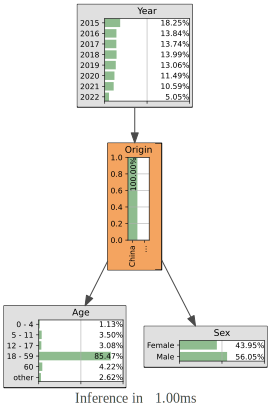

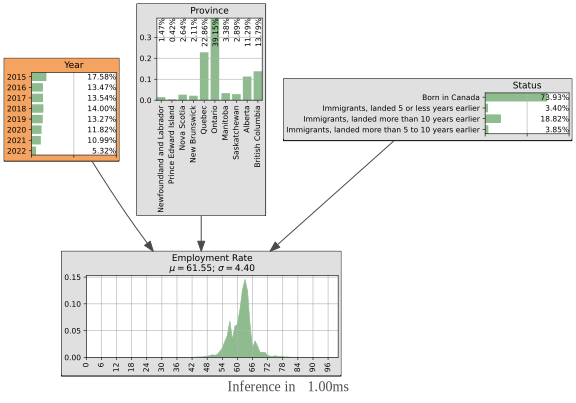

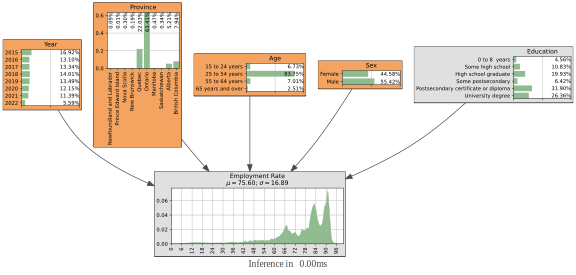

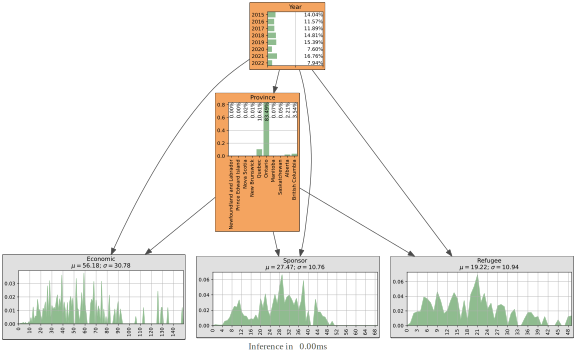

In [17]:
evidence = {"Origin":"China"}

for i in range(4):
    ie=gum.LazyPropagation(model[i])
    
    evidence_match = {}
    
    for name in evidence.keys():
        if name in model[i].names():
            if name == "Age":
                age_distribution = evidence[name]
                if len(age_distribution >= 6):
                    age_12to17 = age_distribution[2]
                    age_18to59 = age_distribution[3]
                    age_60 = age_distribution[4]
                    age_other = age_distribution[5]

                    new_15to24 = age_12to17*3/6 + age_18to59*7/42
                    new_25to54 = age_18to59*29/42
                    new_55to64 = age_18to59*5/42 + age_60
                    new_65 = age_60

                    evidence_match[name] = [new_15to24,new_25to54,new_55to64,new_65]
                else:
                    age_15to24 = age_distribution[0]
                    age_25to54 = age_distribution[1]
                    age_55to64 = age_distribution[2]
                    age_65 = age_distribution[3]
                    
                    
                    age_0to4 = 0
                    age_5to11 = 0                    
                    age_12to17 = age_15to24*3/10
                    age_18to59 = age_15to24*7/10 + age_25to54 *30/30+ age_55to64 * 5/10
                    
                    age_60 = age_55to64 * 1/10
                    age_other = age_65 + age_55to64 * 4/10

                    evidence_match[name] = [age_0to4,age_5to11,age_12to17,age_18to59,age_60,age_other]
            else: 
                evidence_match[name] = evidence[name]
    
    ie.setEvidence(evidence_match)
    ie.makeInference()
    
    for node in model[i].names():
        if node != "Employment Rate":
            evidence[node] = ie.posterior(node).toarray()
        
    gnb.showInference(model[i], evs=evidence_match)


In [ ]:
evidence_match

In [ ]:
evidence.keys()

In [ ]:
model[i].names()

In [ ]:
evidence["Year"]
